<a href="https://colab.research.google.com/github/calladogt/Research-internship/blob/master/Simulators/ks-simulator/KS-modelFF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of the KS system: a model using Feed-Forward Neural Network

 In this notebook, I will use a simple model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given state of the system. To do it, a simple feed-forward neural network will be used.
It is just the first model trained to predict the system. I will try many configurations and varieties.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [1]:
import numpy as np
import torch as th
import time
from scipy import stats
from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Some functions: 

In [3]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [4]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [5]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [6]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [7]:
def prediction(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    
    y_true=state_history_norm_th[start_position:start_position+N_step_pred,:]
    sample_points=state_history_norm_th.size(1)
    current_state = state_history_norm_th[start_position,:]
    prediction_model = th.zeros((N_step_pred, sample_points))


    for i in range(N_step_pred):
        current_state=model(current_state)
        prediction_model[i,:]=current_state


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)

    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [8]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
state_initial = np.loadtxt('u3.dat') #the observed initial state of the system

In [9]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

In [61]:
help(preprocessing.MinMaxScaler)

Help on class MinMaxScaler in module sklearn.preprocessing.data:

class MinMaxScaler(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  MinMaxScaler(feature_range=(0, 1), copy=True)
 |  
 |  Transforms features by scaling each feature to a given range.
 |  
 |  This estimator scales and translates each feature individually such
 |  that it is in the given range on the training set, e.g. between
 |  zero and one.
 |  
 |  The transformation is given by::
 |  
 |      X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
 |      X_scaled = X_std * (max - min) + min
 |  
 |  where min, max = feature_range.
 |  
 |  The transformation is calculated as::
 |  
 |      X_scaled = scale * X + min - X.min(axis=0) * scale
 |      where scale = (max - min) / (X.max(axis=0) - X.min(axis=0))
 |  
 |  This transformation is often used as an alternative to zero mean,
 |  unit variance scaling.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_scaler>`.
 |  
 |  Parameters


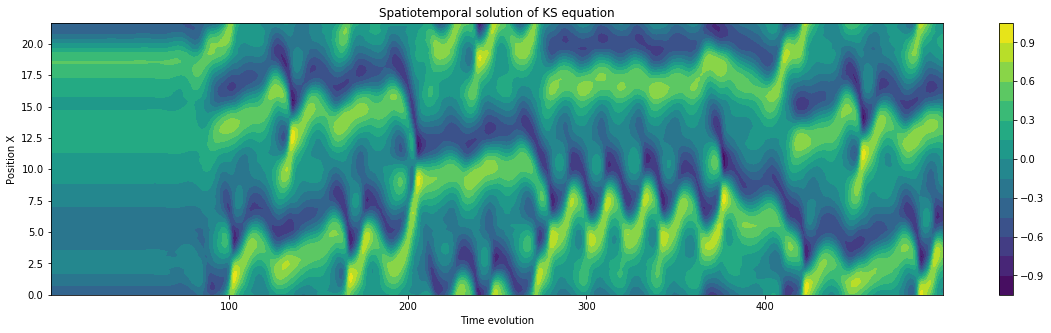

Mean: 0.0037720958739586776
Median: 0.02334210639889245
Max: 0.4565350850600155
Min: -0.4433889069435318
Mode: ModeResult(mode=array([-0.44338891]), count=array([1]))
Variance: 0.05437736519905126


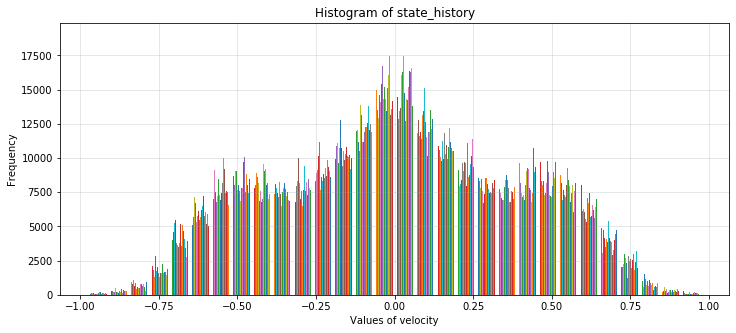

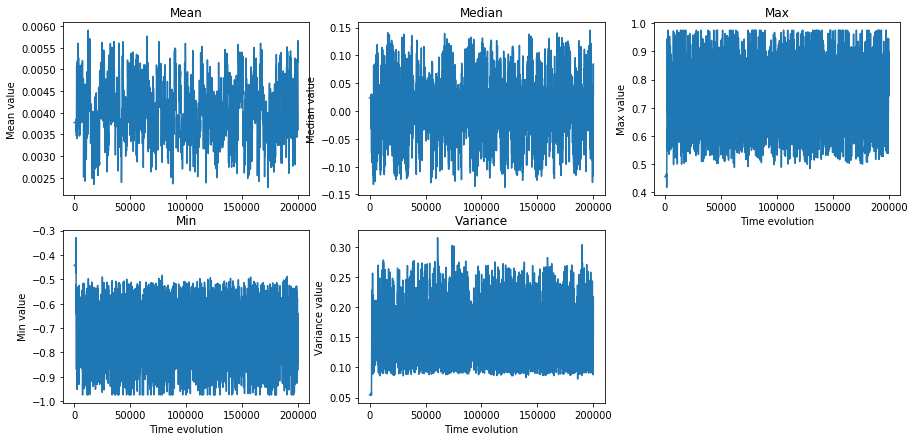

In [10]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#visualizing the solution of KS equation
drawKS(state_history_norm, position_x, time_counter,1,200000,20,4)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

# Separating the data into training and test sets:

In [11]:
X = state_history_norm[:-1,:] #our input: all the data excluding the last one
Y = state_history_norm[1:,:] #our output: all the data minus the first one

NN = state_history_norm.shape[0]-1
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation


np.random.seed(0)
seq=np.arange(X.shape[0])
np.random.shuffle(seq)
train_seq=seq[0:Nt]
valid_seq=seq[-Nv:]
X_train = X[train_seq]
Y_train = Y[train_seq]
X_valid = X[valid_seq]
Y_valid = Y[valid_seq]
#converting to tensor
X_train_th = th.from_numpy(X_train).cuda()
Y_train_th = th.from_numpy(Y_train).cuda()
X_valid_th = th.from_numpy(X_valid).cuda()
Y_valid_th = th.from_numpy(Y_valid).cuda()

In [15]:
#just to use it later:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

# Training

In [12]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.7f}..\t".format(train_losses[-1]),"{:.7f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.7f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

# Model 1

In [52]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.00386..	 0.00387..
1	 0.00384..	 0.00384..
2	 0.00382..	 0.00382..
3	 0.00381..	 0.00382..
4	 0.00380..	 0.00381..
5	 0.00379..	 0.00379..
6	 0.00377..	 0.00376..
7	 0.00376..	 0.00376..
8	 0.00375..	 0.00376..
9	 0.00374..	 0.00374..
10	 0.00372..	 0.00374..
11	 0.00371..	 0.00370..
12	 0.00370..	 0.00369..
13	 0.00369..	 0.00370..
14	 0.00368..	 0.00368..
15	 0.00367..	 0.00365..
16	 0.00365..	 0.00366..
17	 0.00365..	 0.00366..
18	 0.00364..	 0.00362..
19	 0.00363..	 0.00365..
20	 0.00362..	 0.00361..
21	 0.00361..	 0.00360..
22	 0.00360..	 0.00359..
23	 0.00359..	 0.00361..
24	 0.00359..	 0.00360..
25	 0.00358..	 0.00358..
26	 0.00357..	 0.00360..
27	 0.00357..	 0.00358..
28	 0.00356..	 0.00356..
29	 0.00355..	 0.00354..
30	 0.00355..	 0.00354..
31	 0.00354..	 0.00353..
32	 0.00353..	 0.00353..
33	 0.00353..	 0.00352..
34	 0.00352..	 0.00353..
35	 0.00352..	 0.00353..
36	 0.00351..	 0.00350..
37	 0.00350..	 0.00350..
38	 0.00349..	 0.00350..
39	 0.0

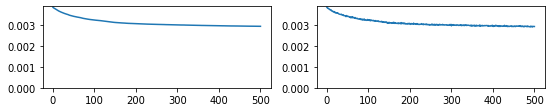

In [56]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [96]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 

#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelff1")

Results for the model 1:

The true solution:


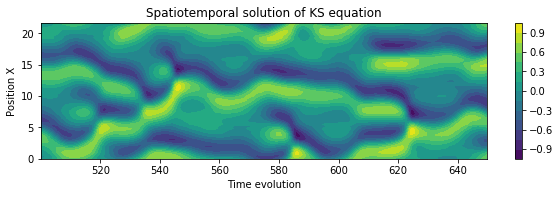

The model solution:


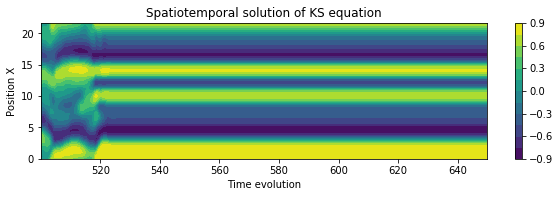

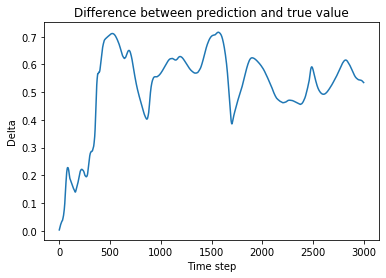

In [15]:
start_position=10000
N_step_pred=3000
prediction(model,start_position,N_step_pred,state_history_norm_th)

# Model 2

In [24]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.31872..	 0.31832..
1	 0.04466..	 0.01553..
2	 0.01420..	 0.01318..
3	 0.01258..	 0.01199..
4	 0.01159..	 0.01117..
5	 0.01091..	 0.01069..
6	 0.01039..	 0.01019..
7	 0.00997..	 0.00983..
8	 0.00963..	 0.00949..
9	 0.00932..	 0.00918..
10	 0.00905..	 0.00895..
11	 0.00881..	 0.00870..
12	 0.00859..	 0.00849..
13	 0.00840..	 0.00833..
14	 0.00821..	 0.00816..
15	 0.00804..	 0.00803..
16	 0.00788..	 0.00778..
17	 0.00774..	 0.00767..
18	 0.00761..	 0.00754..
19	 0.00748..	 0.00743..
20	 0.00736..	 0.00728..
21	 0.00724..	 0.00726..
22	 0.00713..	 0.00706..
23	 0.00703..	 0.00698..
24	 0.00693..	 0.00691..
25	 0.00684..	 0.00679..
26	 0.00674..	 0.00668..
27	 0.00664..	 0.00658..
28	 0.00654..	 0.00651..
29	 0.00645..	 0.00636..
30	 0.00636..	 0.00629..
31	 0.00627..	 0.00622..
32	 0.00618..	 0.00622..
33	 0.00609..	 0.00607..
34	 0.00601..	 0.00594..
35	 0.00592..	 0.00594..
36	 0.00584..	 0.00578..
37	 0.00576..	 0.00571..
38	 0.00568..	 0.00564..
39	 0.0

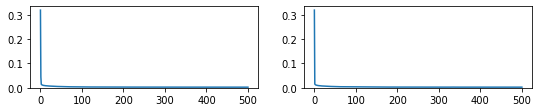

In [25]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [26]:
#TO SAVE THE MODEL

#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv3_model2_u3")
# Write a pickle file using pytorch 
th.save(tosave_data, "modelff2")

The true solution:


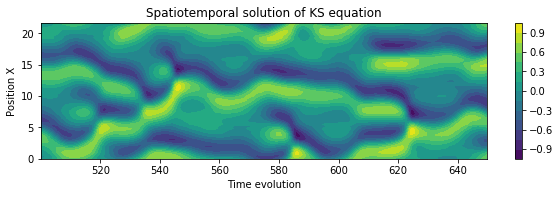

The model solution:


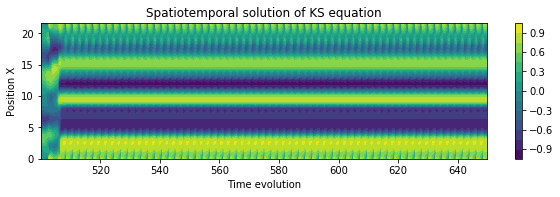

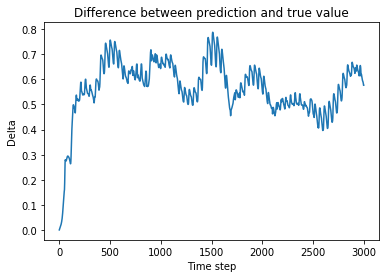

In [27]:
start_position=10000
N_step_pred=3000
prediction(model,start_position,N_step_pred,state_history_norm_th)

# Model 3

In [28]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.Tanh(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.TanhU(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-4)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.31843..	 0.31816..
1	 0.04393..	 0.01552..
2	 0.01409..	 0.01307..
3	 0.01250..	 0.01205..
4	 0.01159..	 0.01118..
5	 0.01092..	 0.01074..
6	 0.01039..	 0.01023..
7	 0.00995..	 0.00980..
8	 0.00958..	 0.00939..
9	 0.00925..	 0.00907..
10	 0.00895..	 0.00890..
11	 0.00869..	 0.00859..
12	 0.00845..	 0.00847..
13	 0.00823..	 0.00824..
14	 0.00802..	 0.00800..
15	 0.00784..	 0.00772..
16	 0.00769..	 0.00768..
17	 0.00754..	 0.00758..
18	 0.00741..	 0.00726..
19	 0.00729..	 0.00720..
20	 0.00716..	 0.00709..
21	 0.00706..	 0.00693..
22	 0.00695..	 0.00686..
23	 0.00684..	 0.00683..
24	 0.00674..	 0.00675..
25	 0.00666..	 0.00665..
26	 0.00657..	 0.00650..
27	 0.00649..	 0.00646..
28	 0.00641..	 0.00638..
29	 0.00634..	 0.00623..
30	 0.00627..	 0.00615..
31	 0.00619..	 0.00615..
32	 0.00613..	 0.00612..
33	 0.00606..	 0.00606..
34	 0.00600..	 0.00603..
35	 0.00594..	 0.00602..
36	 0.00587..	 0.00578..
37	 0.00581..	 0.00579..
38	 0.00575..	 0.00572..
39	 0.0

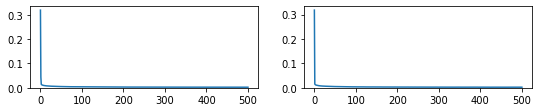

In [29]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [30]:
#TO SAVE THE MODEL

#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv3_model2_u3")

The true solution:


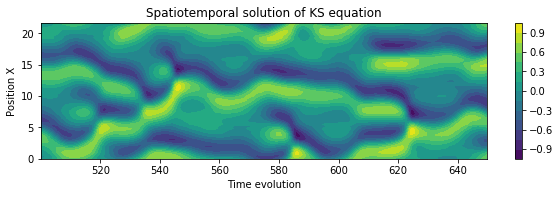

The model solution:


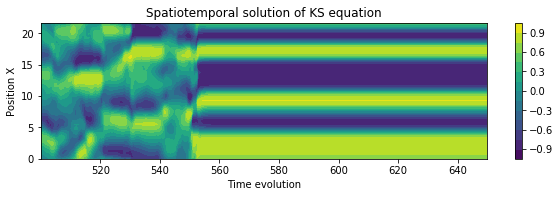

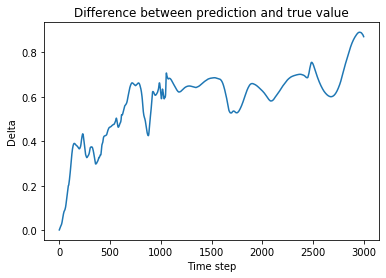

In [31]:
start_position=10000
N_step_pred=3000
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 4

In [33]:
n_input=64
n_output=64
n_hidden=128
model = th.nn.Sequential(
    th.nn.Linear(n_input,n_hidden),
    th.nn.LeakyReLU(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.Tanh(),
    th.nn.Linear(n_hidden,n_hidden),
    th.nn.Tanh(),
    th.nn.Linear(n_hidden,n_output),
    th.nn.Tanh()
)
model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.L1Loss()

Epoch	Train Loss	Valid Loss
0	 0.31988..	 0.31961..
1	 0.18213..	 0.08967..
2	 0.06289..	 0.03782..
3	 0.02956..	 0.02462..
4	 0.02229..	 0.02074..
5	 0.01975..	 0.01893..
6	 0.01826..	 0.01768..
7	 0.01720..	 0.01678..
8	 0.01643..	 0.01611..
9	 0.01583..	 0.01558..
10	 0.01536..	 0.01515..
11	 0.01496..	 0.01478..
12	 0.01461..	 0.01446..
13	 0.01431..	 0.01418..
14	 0.01404..	 0.01392..
15	 0.01380..	 0.01369..
16	 0.01359..	 0.01349..
17	 0.01339..	 0.01330..
18	 0.01321..	 0.01312..
19	 0.01304..	 0.01296..
20	 0.01288..	 0.01281..
21	 0.01274..	 0.01267..
22	 0.01260..	 0.01253..
23	 0.01247..	 0.01241..
24	 0.01234..	 0.01230..
25	 0.01222..	 0.01217..
26	 0.01211..	 0.01206..
27	 0.01199..	 0.01195..
28	 0.01188..	 0.01185..
29	 0.01178..	 0.01174..
30	 0.01168..	 0.01165..
31	 0.01158..	 0.01154..
32	 0.01148..	 0.01145..
33	 0.01139..	 0.01135..
34	 0.01130..	 0.01127..
35	 0.01121..	 0.01118..
36	 0.01112..	 0.01109..
37	 0.01103..	 0.01101..
38	 0.01095..	 0.01091..
39	 0.0

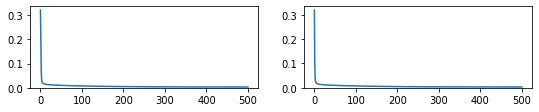

In [34]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

The true solution:


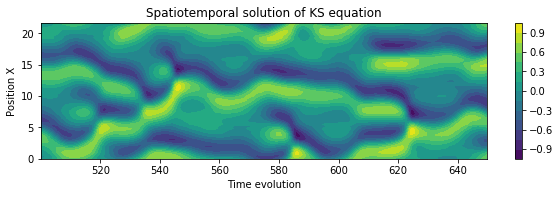

The model solution:


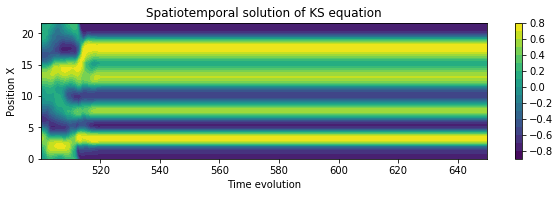

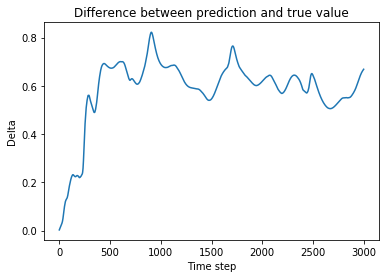

In [36]:
start_position=10000
N_step_pred=3000
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [37]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv3_model2_u3")
th.save(tosave_data, "modelff4")

Sequential(
  (0): Linear(in_features=64, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Tanh()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Tanh()
)
Model's state_dict:
0.weight 	 torch.Size([128, 64])
0.bias 	 torch.Size([128])
2.weight 	 torch.Size([128, 128])
2.bias 	 torch.Size([128])
4.weight 	 torch.Size([128, 128])
4.bias 	 torch.Size([128])
6.weight 	 torch.Size([64, 128])
6.bias 	 torch.Size([64])
epoch: 500
batch_size: 64
loss: L1Loss()


(0, 0.3354280062968297)

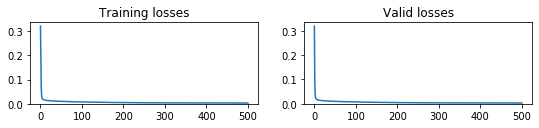

In [13]:
# Load the pickle file to read the dictionnary from the file
checkpoint = th.load("modelff4")

# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']


# Print model's state_dict
print(model)
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("epoch:", epoch)
print("batch_size:", batch_size)
print("loss:", loss_fn)
    
# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

#plot some graphs
plt.figure(figsize = (9, 1.5))
ax= plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training losses')
ax.set_ylim(bottom=0)
ax= plt.subplot(1, 2, 2)
plt.plot(valid_losses)
plt.title('Valid losses')
ax.set_ylim(bottom=0)

The true solution:


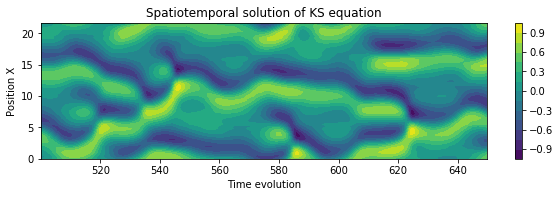

The model solution:


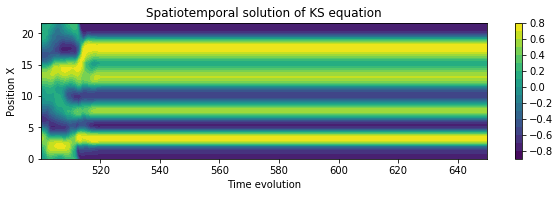

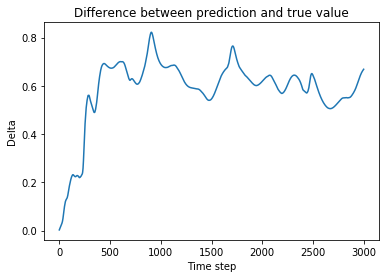

In [17]:
start_position=10000
N_step_pred=3000
prediction(model,start_position,N_step_pred,state_history_norm_th)